<a href="https://colab.research.google.com/github/Andre-Pereira01/Projeto-Final-Deep-Learning/blob/main/Projeto_Final_Deep_Learning_Avan%C3%A7ado_Andr%C3%A9_Pereira_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

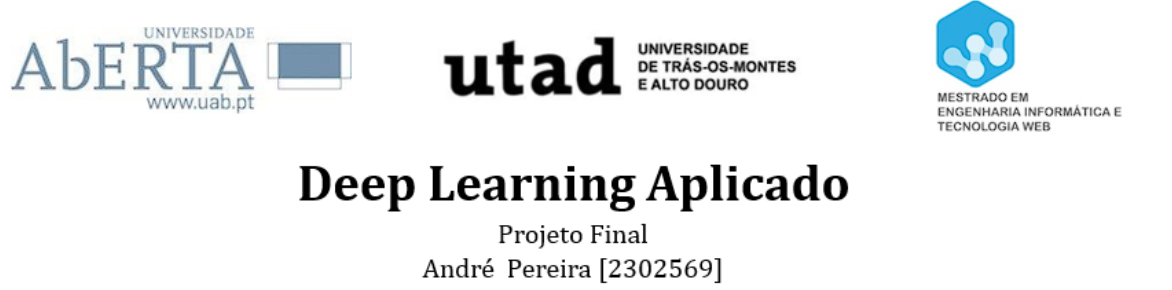

# Introdução

As imagens de plantas medicinais capturadas em dispositivos móveis desempenham um papel significativo na identificação de espécies de plantas para pesquisas científicas. O conjunto de dados DIMPSAR (Dataset for Indian medicinal plant species analysis and recognition) contribui de maneira crucial para essa pesquisa, fornecendo 5900 imagens de quarenta plantas medicinais, incluindo características como múltiplas resoluções, variações de iluminação, fundos diversos e amostras capturadas em condições de tempo e estações do ano distintas.

Este trabalho visa utilizar o conjunto de dados DIMPSAR para a detecção e classificação de diferentes tipos de plantas medicinais por meio de redes neurais convolucionais (CNNs), explorando assim as potencialidades da visão computacional na análise e reconhecimento de espécies de plantas medicinais.

-Link para artigo sobre a DIMPSAR: https://www.sciencedirect.com/science/article/pii/S2352340923005000


# Preparação do Ambiente
Nesta seção realizamos a preparação do ambiente no Google Colab onde instalamos o kaggle e preparamos os procedimentos necessários para fazer o download do conjunto de dados e dar unzip no mesmo.


NOTA: O dataset não estava no kaggle originalmente, mas para aproveitar a api do kaggle, dei upload do dataset na minha conta kaggle de forma a acelarar o processo.

link do dataset original: https://data.mendeley.com/datasets/748f8jkphb/3


In [1]:
!pip install kaggle #installing Kaggle
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrepereira2001/dimpsar
!unzip -q "dimpsar.zip"

Saving kaggle.json to kaggle.json
100% 8.99G/9.00G [01:47<00:00, 96.5MB/s]
100% 9.00G/9.00G [01:47<00:00, 89.5MB/s]


# **Importação de Bibliotecas e Exploração Inicial**
Esta seção tem como objetivo importar as bibliotecas necessárias para o desenvolvimento do projeto. Cada biblioteca desempenha um papel específico nas tarefas relacionadas à análise e classificação de imagens de plantas medicinais.


In [2]:
# Importar as bibliotecas que vamos precisar
import os as os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pathlib import Path
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from pathlib import Path
import random
import cv2
import imutils
from skimage.io import imread

# **Carregamento e Organização do Conjunto de Dados**

O código está dedicado ao carregamento e organização do conjunto de dados que será utilizado no treino do modelo. O conjunto de dados é dividido em duas partes principais: folhas e plantas medicinais.

Para cada parte, o código realiza as seguintes etapas:

- Especifica os caminhos principais para os diretórios que contém as imagens das folhas e plantas.

- Utiliza a biblioteca Path para iterar sobre os subdiretórios e recolhe informações sobre as imagens, como o caminho completo e a classe a que pertencem (nome da planta ou folha).

- Armazena essas informações em DataFrames pandas, sendo um DataFrame para folhas (df_leaf) e outro para plantas (df_plant).


In [3]:

# Carregar conjunto de dados de folhas
main_folder_leaf = '/content/Indian Medicinal Leaves Image Datasets/Medicinal Leaf dataset'
sub_folders_leaf = Path(main_folder_leaf).glob('*')

rows_leaf = []
for folder_leaf in sub_folders_leaf:
    class_name_leaf = str(folder_leaf).replace(main_folder_leaf + "/", "")
    for file_leaf in os.listdir(folder_leaf):
        data_leaf = [str(folder_leaf) + "/" + file_leaf, class_name_leaf]
        rows_leaf.append(data_leaf)

# Armazenar todos os dados em um DataFrame pandas
df_leaf = pd.DataFrame(rows_leaf, columns=["Full Path", "Class Name"])

# Carregar conjunto de dados de plantas
main_folder_plant = '/content/Indian Medicinal Leaves Image Datasets/Medicinal plant dataset'
sub_folders_plant = Path(main_folder_plant).glob('*')

rows_plant = []
for folder_plant in sub_folders_plant:
    class_name_plant = str(folder_plant).replace(main_folder_plant + "/", "")
    for file_plant in os.listdir(folder_plant):
        data_plant = [str(folder_plant) + "/" + file_plant, class_name_plant]
        rows_plant.append(data_plant)

# Armazenar todos os dados em um DataFrame pandas
df_plant = pd.DataFrame(rows_plant, columns=["Full Path", "Class Name"])


# **Definição e Construção do Modelo CNN**
Nesta parte estabelecemos a construção e o treino do modelo CNN para a classificação de imagens de folhas e das plantas.
Começamos por definir as constantes:

- IMG_SIZE: Tamanho padrão das imagens de entrada.
- CHANNELS: Número de canais de cor nas imagens (3 para imagens coloridas e RGB).
- CLASSES_LEAF: Número de classes (espécies de folhas) no conjunto de dados de folhas.
- CLASSES_PLANT: Número de classes (espécies de plantas) no conjunto de dados de plantas.
- EPOCH: Número de épocas de treino.
- BATCH_SIZE: Tamanho do batch para as iterações.
- LR: Taxa de aprendizagem do otimizador Adam.
- SEED: Semente aleatória para reprodutibilidade.

**Arquitetura do Modelo para as folhas**: Utilizo a arquitetura pré-treinada MobileNetV3Large como base. Depois adiciono camadas globais (Global Average Pooling) para reduzir a dimensionalidade. De seguida ponho camadas densas para a aprendizagem ser mais profunda. Na camada de saída adiciona-se a ativação softmax para a classificação multiclasse. De seguida compilamos o modelo com cross entropy como função de perda e também o Adam. O modelo mostra informações sobre parâmetros, camadas e ligações.

A arquitetura do Modelo para plantas repete o processo para criar um modelo semelhante para o conjunto de dados de plantas medicinais e fornece um resumo detalhado da arquitetura do modelo para plantas.


**MobileNetV3Large:** é uma arquitetura CNN projetada para tarefas de visão computacional, é notável pelo seu desempenho eficiente em termos de computação e tamanho do modelo. Utiliza blocos de operações chamados blocos 'inverted residuals', que consistem em convoluções profundas seguidas por convoluções mais leves. Esta abordagem permite uma representação rica de características com menor custo computacional. O modelo é escalável, podendo ser adaptado para diferentes tamanhos de entrada e requisitos de computação. A camada de saída do MobileNetV3Large é removida e substituída por camadas adicionais personalizadas para se adequar à tarefa específica de classificação de folhas e plantas medicinais.

Para um melhor entendimento do modelo consultei um vídeo:
https://youtu.be/0oqs-inp7sA?si=wnPaoFa_ujntBrEj
e também um paper: https://arxiv.org/pdf/1905.02244.pdf


In [4]:
# Definir constantes
IMG_SIZE = 224
CHANNELS = 3
CLASSES_LEAF = len(df_leaf["Class Name"].unique())
CLASSES_PLANT = len(df_plant["Class Name"].unique())
EPOCH = 10
BATCH_SIZE = 32
LR = 0.0001
SEED = 42

# Definir a arquitetura do modelo para folhas
mobilenetv3_leaf = MobileNetV3Large(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
x_leaf = GlobalAveragePooling2D()(mobilenetv3_leaf.output)
x_leaf = Dense(512, activation='relu')(x_leaf)
x_leaf = Dense(1024, activation='relu')(x_leaf)
classifier_leaf = Dense(CLASSES_LEAF, activation='softmax')(x_leaf)
model_leaf = Model(name="MedNetLeaf", inputs=mobilenetv3_leaf.input, outputs=classifier_leaf)

# Compilar o modelo para folhas
opt_leaf = Adam(learning_rate=LR)
model_leaf.compile(loss="categorical_crossentropy", optimizer=opt_leaf, metrics=['accuracy'])

# Resumo do modelo para folhas
model_leaf.summary()

# Definir a arquitetura do modelo para plantas
mobilenetv3_plant = MobileNetV3Large(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
x_plant = GlobalAveragePooling2D()(mobilenetv3_plant.output)
x_plant = Dense(512, activation='relu')(x_plant)
x_plant = Dense(1024, activation='relu')(x_plant)
classifier_plant = Dense(CLASSES_PLANT, activation='softmax')(x_plant)
model_plant = Model(name="MedNetPlant", inputs=mobilenetv3_plant.input, outputs=classifier_plant)

# Compilar o modelo para plantas
opt_plant = Adam(learning_rate=LR)
model_plant.compile(loss="categorical_crossentropy", optimizer=opt_plant, metrics=['accuracy'])

# Resumo do modelo para plantas
model_plant.summary()

12683000/12683000 [==============================] - 0s 0us/step
Model: "MedNetLeaf"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)              

# Preparação e Treino dos Modelos CNN para Folhas e Plantas

Começamos então por preparar os conjuntos de dados usando a biblioteca ImageDataGenerator do TensorFlow para aumentar a diversidade do conjunto de dados, aplicando transformações nas imagens em tempo real durante o treino, como por exemplo rotação, zoom, inversão horizontal, etc.
O conjunto de dados é dividido em conjuntos de treino e validação (25% para validação) para avaliar o desempenho do modelo em dados não vistos.
São ajustados geradores de dados separados para folhas e plantas, com especificações para o caminho das imagens, colunas de rótulos, tamanho do lote, semente para reprodutibilidade, modo de classe categórica e tamanho alvo das imagens.

Passamos ao treino dos modelos, os modelos foram construidos para folhas e plantas utilizando a arquitetura MobileNetV3Large. Estes modelos são destinados a aprender representações de alto nível das imagens. A função de ativação ReLU é utilizada nas camadas intermediárias para introduzir não linearidades, e a camada de saída utiliza a função softmax para produzir probabilidades para cada classe.
O otimizador Adam é utilizado para ajustar os pesos do modelo durante o treinamento, e a função de perda é a 'categoric cross entropy', apropriada para problemas de classificação com múltiplas classes.

Durante o treino, as métricas de precisão e perda são registadas para análise posterior. Os resultados do treino são visualizados em gráficos. Os gráficos de precisão mostram como a precisão do modelo evolui ao longo das épocas, tanto para o conjunto de treino quanto para o de validação. Da mesma forma, os gráficos de perda indicam como a perda diminui durante o treino.
A visualização destas métricas permite uma análise detalhada do desempenho do modelo ao longo do tempo, identificando possíveis problemas como overfitting ou underfitting.

In [5]:

# Preparar e dividir conjunto de dados para folhas
train_datagen_leaf = ImageDataGenerator(validation_split=0.25)
train_generator_leaf = train_datagen_leaf.flow_from_dataframe(
    dataframe=df_leaf,
    x_col="Full Path",
    y_col="Class Name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE, IMG_SIZE)
)

validation_generator_leaf = train_datagen_leaf.flow_from_dataframe(
    dataframe=df_leaf,
    x_col="Full Path",
    y_col="Class Name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE, IMG_SIZE)
)

# Preparar e dividir conjunto de dados para plantas
train_datagen_plant = ImageDataGenerator(validation_split=0.25)
train_generator_plant = train_datagen_plant.flow_from_dataframe(
    dataframe=df_plant,
    x_col="Full Path",
    y_col="Class Name",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE, IMG_SIZE)
)

validation_generator_plant = train_datagen_plant.flow_from_dataframe(
    dataframe=df_plant,
    x_col="Full Path",
    y_col="Class Name",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMG_SIZE, IMG_SIZE)
)

# Treinar o modelo para folhas
history_leaf = model_leaf.fit(
    train_generator_leaf,
    epochs=EPOCH,
    validation_data=validation_generator_leaf,
    batch_size=BATCH_SIZE
)

# Treinar o modelo para plantas
history_plant = model_plant.fit(
    train_generator_plant,
    epochs=EPOCH,
    validation_data=validation_generator_plant,
    batch_size=BATCH_SIZE
)


Found 5175 validated image filenames belonging to 80 classes.
Found 1725 validated image filenames belonging to 80 classes.
Found 4459 validated image filenames belonging to 40 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Full Path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 4 invalid image filename(s) in x_col="Full Path". These filename(s) will be ignored.
  warnings.warn(


Found 1486 validated image filenames belonging to 40 classes.
Epoch 1/10
162/162 [==============================] - 338s 2s/step - loss: 2.6584 - accuracy: 0.4004 - val_loss: 12.6386 - val_accuracy: 0.0104
Epoch 2/10
162/162 [==============================] - 283s 2s/step - loss: 0.4816 - accuracy: 0.8823 - val_loss: 15.3191 - val_accuracy: 0.0301
Epoch 3/10
162/162 [==============================] - 282s 2s/step - loss: 0.1191 - accuracy: 0.9822 - val_loss: 16.5119 - val_accuracy: 0.0133
Epoch 4/10
162/162 [==============================] - 286s 2s/step - loss: 0.0441 - accuracy: 0.9946 - val_loss: 17.3190 - val_accuracy: 0.0359
Epoch 5/10
162/162 [==============================] - 286s 2s/step - loss: 0.0247 - accuracy: 0.9975 - val_loss: 18.0536 - val_accuracy: 0.0452
Epoch 6/10
162/162 [==============================] - 282s 2s/step - loss: 0.0225 - accuracy: 0.9959 - val_loss: 18.2346 - val_accuracy: 0.0406
Epoch 7/10
162/162 [==============================] - 281s 2s/step - loss:

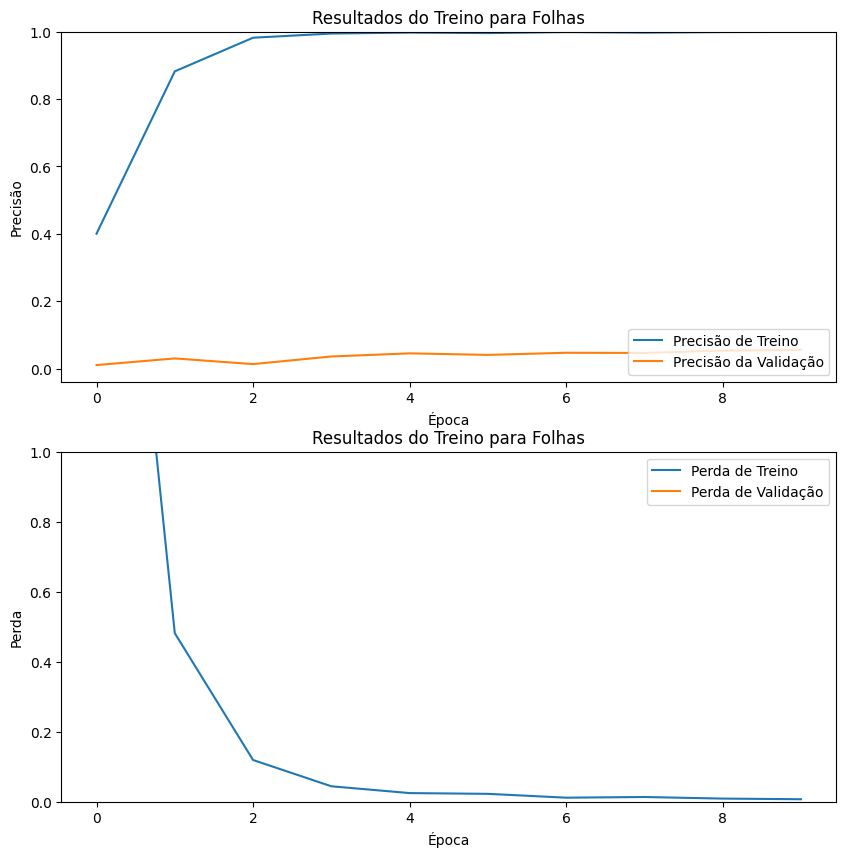

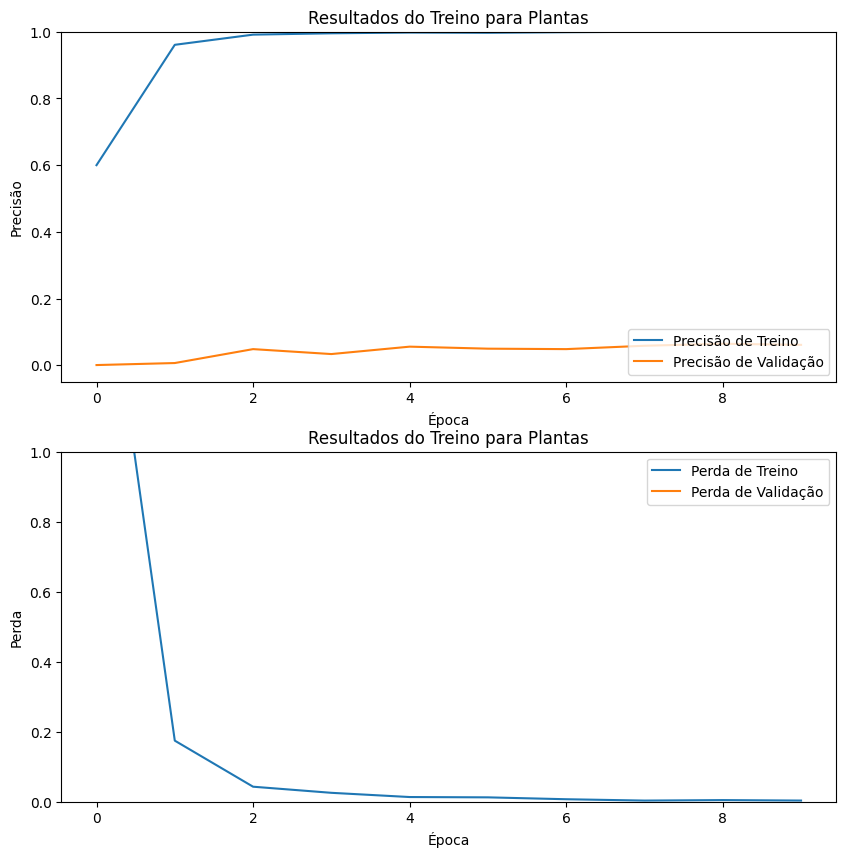

In [6]:
# Visualizar resultados do treinamento para folhas
acc_leaf = history_leaf.history['accuracy']
val_acc_leaf = history_leaf.history['val_accuracy']

loss_leaf = history_leaf.history['loss']
val_loss_leaf = history_leaf.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_leaf, label='Precisão de Treino')
plt.plot(val_acc_leaf, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.ylabel('Precisão')
plt.ylim([min(plt.ylim()), 1])
plt.xlabel('Época')
plt.title('Resultados do Treino para Folhas')

plt.subplot(2, 1, 2)
plt.plot(loss_leaf, label='Perda de Treino')
plt.plot(val_loss_leaf, label='Perda de Validação')
plt.legend(loc='upper right')
plt.ylabel('Perda')
plt.ylim([0, 1.0])
plt.title('Resultados do Treino para Folhas')
plt.xlabel('Época')
plt.show()

# Visualizar resultados do treinamento para plantas
acc_plant = history_plant.history['accuracy']
val_acc_plant = history_plant.history['val_accuracy']

loss_plant = history_plant.history['loss']
val_loss_plant = history_plant.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_plant, label='Precisão de Treino')
plt.plot(val_acc_plant, label='Precisão de Validação')
plt.legend(loc='lower right')
plt.ylabel('Precisão')
plt.ylim([min(plt.ylim()), 1])
plt.xlabel('Época')
plt.title('Resultados do Treino para Plantas')

plt.subplot(2, 1, 2)
plt.plot(loss_plant, label='Perda de Treino')
plt.plot(val_loss_plant, label='Perda de Validação')
plt.legend(loc='upper right')
plt.ylabel('Perda')
plt.ylim([0, 1.0])
plt.title('Resultados do Treino para Plantas')
plt.xlabel('Época')
plt.show()

# Análise dos resultados obtidos

Os resultados do treino dos dois modelos de classificação de imagens (um com 80 classes e outro com 40 classes) revelam insights interessantes sobre o seu desempenho. Aqui está uma análise das principais observações:

- Para o modelo com 80 classes, havia 5175 imagens validadas para treino e 1725 para validação. O modelo com 40 classes tinha 4459 imagens de treino e 1486 imagens de validação.

- Ambos os modelos encontraram avisos sobre 4 nomes de arquivo de imagem inválidos durante o treino, que foram ignorados.

- A arquitetura de ambos os modelos envolve camadas convolucionais, pooling, normalização em lotes e camadas densas, concluindo com uma camada de pooling global média e camadas densas para classificação.

- Os modelos passaram por 10 épocas de treino. O modelo com 80 classes atingiu uma precisão de aproximadamente 99,94% no conjunto de treino e 5,57% no conjunto de validação.
O modelo com 40 classes alcançou uma precisão de cerca de 99,96% no conjunto de treinamento e 6,12% no conjunto de validação.


- Existe uma tendência de diminuição da perda de treino e aumento da precisão durante as primeiras épocas nos 2 modelos. No entanto, a precisão de validação mostra sinais de overfitting, divergindo da precisão de treino.


Desafios e Considerações:

A diferença significativa entre a precisão de treinamento e validação sugere overfitting. Técnicas de regularização, como dropout ou aumento de dados, poderiam ser exploradas.

Ideias para a melhoria:

Vou então na próxima parte adicionar técnicas de regularização e talvez hiperparâmetros para melhorar o desempenho de generalização. Posso tentar também explorar etapas adicionais de pré-processamento de dados.
